# 1. Overview
In this assignment, you will perform a first-principles electronic structure calculation for the semiconductor GaAs using Quantum ESPRESSO.
You will:

- Run a self-consistent field (SCF) calculation
- Run a non-self-consistent (NSCF) band calculation
- Perform post-processing with bands.x
- Generate a band structure diagram with python
- Understand the input files, pseudopotentials, and k-point sampling

The exercise strengthens your understanding of plane-wave DFT workflows and band-structure analysis.

# 2. Files Provided
You can download the following files from LEARN Lab003_Assigment.

## Input Files
- GaAs.scf.in
- GaAs.nscf.in ( to be edited with the number of band)
- GaAs.band.in

## Pseudopotentials
- Ga.pbe-dn-kjpaw_psl.1.0.0.UPF
- As.pbe-n-kjpaw_psl.1.0.0.UPF

## plots
- plot.py ( to be edited with the fermi energy)

# 3. Task Instructions
Download and extract the prepared script directory:

# 4. Understanding the Input Files
## 4.1 SCF Input (GaAs.scf.in)
- &control — calculation type, prefix, file paths
- &system — lattice, atomic types, cutoff energies
- &electrons — convergence settings
- ATOMIC_SPECIES — elements + pseudopotentials
- ATOMIC_POSITIONS — internal coordinates
- K_POINTS {automatic} — 8×8×8 grid

## Key physics concepts:
- GaAs uses zinc-blende structure (fcc-based).
- Cutoff energies (ecutwfc=60, ecutrho=244) follow pseudopotential  recommendations.
- SCF uses a coarse k-point grid because only electron density is required.

## 4.2 NSCF Input (GaAs.nscf.in)
Changes from SCF:

- calculation = 'bands'
- Added nbnd = xxx
- K_POINTS {crystal_b} — piecewise-defined high-symmetry path:
- L → Γ → X → K/U → Γ

Purpose: Use the SCF density to compute eigenvalues along the band path.

### Changes Needed for a Band-Structure (NSCF) Calculation
To compute a band structure, we start from the converged SCF density and run a non-self-consistent (NSCF) calculation along a high-symmetry k-path. This requires several key changes to the SCF input.

`calculation = 'bands'`
Tells the code to:

- Use the SCF charge density
- Compute eigenvalues only
- Follow a manually defined k-path instead of a uniform k-grid

`nbnd = xxx`
Specifies the number of electronic bands to compute.

- SCF only requires enough occupied bands
- Band plots need extra conduction bands
- Choosing ~2–3× the number of occupied bands is typical

### 2. How to Determine nbnd
Quantum ESPRESSO automatically determines the number of occupied bands from the valence electrons.

Number of electrons 𝑁𝑒=sum of pseudopotential valence electrons

Then the number of occupied bands is: 𝑁occ=⌈𝑁𝑒/2⌉
 (for spin-unpolarized systems)

Example

If your system has 20 valence electrons per primitive cell: 𝑁occ=202=10occupied bands

For a band structure calculation, you also need extra empty (conduction) bands.

Rule of Thumb

Insulators:
𝑛𝑏𝑛𝑑=𝑁occ+4–8

Metals:
𝑛𝑏𝑛𝑑=𝑁occ+8–16

Complex systems:
𝑛𝑏𝑛𝑑=2𝑁occ

How to Check Automatically

After the SCF run completes, QE prints:

```
number of Kohn-Sham states = XX
```
This value is the minimum nbnd. Add the recommended number of conduction bands on top.

K_POINTS {crystal_b}
This block defines the high-symmetry k-path used in band-structure plots.

Example path for GaAs: L → Γ → X → K/U → Γ


# 5 . Post-Processing
GaAs.band.in (for bands.x) contains:

```
&amp;bands
prefix = 'GaAs'
lsym = .true.
/
```

This generates bands.out.gnu, which is plotted by plot.gp or by plot.py

# 6. Task Instructions Running the Calculations (HPC / SLURM )
This section explains how to run the SCF, NSCF, and band‐structure post-processing steps for GaAs using Quantum ESPRESSO on an HPC cluster with SLURM. All commands below assume you are inside the directory containing:

- GaAs.scf.in ( to be edited )
- GaAs.nscf.in ( to be edited with the number of band)
- GaAs.band.in
- plot.py ( to be edited with the fermi energy)
- Pseudopotentials (Ga.UPF, As.UPF)
- Any job scripts you prepare (run_scf.slurm, run_nscf.slurm, etc.)

## Step 1 — SCF Calculation
modify the GaAs.scf.in : add `verbosity = 'high' in the &control and

Submit the self-consistent calculation to SLURM:

```
sbatch run_scf.slurm
```

Where your run_scf.slurm job script should contain something like:
```
#!/bin/bash
#SBATCH --job-name=GaAs_scf
#SBATCH --nodes=1
#SBATCH --ntasks=4
#SBATCH --time=00:10:00

module load quantum-espresso

mpirun pw.x < GaAs.scf.in > GaAs.scf.out
```

## Step 2 — NSCF Band Calculation
After the SCF job finishes and produces a converged charge density (GaAs.save/),

Look in GaAs.scf.out

Search for:
```
the Fermi energy is   
```

or

```
highest occupied level (ev): 
```

Also search for

```
number of Kohn-Sham states = XX
```

then edit

`GaAs.nscf.in`

```
nbnd = XX + Nextra
```

submit:

```
sbatch run_nscf.slurm
```

Example NSCF job script:
```
#!/bin/bash
#SBATCH --job-name=GaAs_nscf
#SBATCH --nodes=1
#SBATCH --ntasks=4
#SBATCH --time=00:10:00

module load quantum-espresso

mpirun pw.x < GaAs.nscf.in > GaAs.nscf.out
```

## Step 3 — Band Post-Processing
Once NSCF completes:
```
sbatch run_bands.slurm
```
Example:
```
#!/bin/bash
#SBATCH --job-name=GaAs_bands
#SBATCH --nodes=1
#SBATCH --ntasks=4
#SBATCH --time=00:05:00

module load quantum-espresso

mpirun bands.x < GaAs.band.in > GaAs.band.out
```

This generates the file GaAs.band.gnu for plotting.

## Step 4 — Plotting the Band Structure
python   plot.gp
This will produce a band-structure figure (e.g., band.png or band.eps depending on your plot.gp settings).

# Running the Simulations

## Step 1
-----
The first step is to run the SCF Calculation, so I used the following files :

### `GaAs.scf.in`
-----
```in
&control
    calculation = 'scf'
    prefix = 'GaAs'
    pseudo_dir = './'
    wf_collect = .true.
    verbosity = 'high'
    outdir = './tmp/'
/
&system
    ibrav = 2
    celldm(1) = 10.6867
    nat = 2
    ntyp = 2
    ecutwfc = 60
    ecutrho = 244
/
&electrons
    mixing_mode = 'plain'
    mixing_beta = 0.7
    conv_thr = 1.0d-8
/
ATOMIC_SPECIES
    Ga 69.723 Ga.pbe-dn-kjpaw_psl.1.0.0.UPF
    As 74.921595 As.pbe-n-kjpaw_psl.1.0.0.UPF
ATOMIC_POSITIONS
    Ga 0.00 0.00 0.00
    As 0.25 0.25 0.25
K_POINTS {automatic}
    8 8 8 0 0 0
```

### `run-scf .sh`
-----
```sh
#!/bin/bash
#SBATCH --job-name=GaAs_scf
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --time=01:00:00
#SBATCH --mem-per-cpu=4000M 
#SBATCH --cpus-per-task=2  # 1 thread per rank

module load class-simulations

mpirun -np $SLURM_NTASKS pw.x < GaAs.scf.in > GaAs.scf.out
```

### Calculation Results
-----
Once the calculation finished I extracted the following Values from the Output File :
- `Highest Occupied Level` : 6.7106 eV
- `Number of Kohn-Sham States` : 9

This means that for `nbnd` in the `NSCF` calculation I need to run it with $9 + N_{extra}$ bands. In my case I will add 7 bands since the range of a Semiconductor is 4-8. So the value I will use is :
- `nbnd` : 16 

Now I'll run the second step...

## Step 2
------
Now for the second step, using the $nbnd = 16$ established from the previous section I use the following files to run the `NSCF` calculation

### GaAs.nscf.in
```
&control
    calculation = 'bands'
    prefix = 'GaAs'
    pseudo_dir = './'
    wf_collect = .true.
    verbosity = 'high'
    outdir = './tmp/'
/
&system
    ibrav = 2
    celldm(1) = 10.6867
    nat = 2
    ntyp = 2
    ecutwfc = 60
    ecutrho = 244
    nbnd =  16
/
&electrons
    mixing_mode = 'plain'
    mixing_beta = 0.7
    conv_thr = 1.0d-8
    diago_david_ndim = 4
/
ATOMIC_SPECIES
    Ga 69.723 Ga.pbe-dn-kjpaw_psl.1.0.0.UPF
    As 74.921595 As.pbe-n-kjpaw_psl.1.0.0.UPF
ATOMIC_POSITIONS
    Ga 0.00 0.00 0.00
    As 0.25 0.25 0.25
K_POINTS {crystal_b}
    5
    0.00  0.50  0.00  20 !L
    0.00  0.00  0.00  30 !G
    -0.50  0.00 -0.50  10 !X
    -0.375 0.00 -0.675 30 !K,U
    0.00  0.00 -1.00  20 !G
```

### run-nscf.sh
```sh
#!/bin/bash
#SBATCH --job-name=GaAs_nscf
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --time=01:00:00
#SBATCH --mem-per-cpu=4000M 
#SBATCH --cpus-per-task=2  # 1 thread per rank

module load class-simulations

mpirun -np $SLURM_NTASKS pw.x < GaAs.nscf.in > GaAs.nscf.out
```

### Calculation Results
-------
No specific data was requested as a result, I just transferred the results `/tmp` folder to the `Band` calculation folder and started running the Step 3 calculations

## Step 3
------
For the third step I ran the following input file 
### GaAs.band.in
----
```
&bands
   outdir = './tmp/',
   prefix='GaAs',
   filband='GaAs.band',
   lsym=.true.
/
```

### run-bands.sh
-----
```sh
#!/bin/bash
#SBATCH --job-name=GaAs_bands
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --time=01:00:00
#SBATCH --mem-per-cpu=4000M 
#SBATCH --cpus-per-task=2  # 1 thread per rank

module load class-simulations

mpirun -np $SLURM_NTASKS bands.x < GaAs.band.in > GaAs.band.out
```

### Calculation Results
------
After running this calculation I received the following files :
- GaAs.band.gnu
- GaAs.band.rap

The file `GaAs.band.gnu` will be used to plot the Band Gaps using the plotting functionality in the next section

## Step 4
------
In this step we need to plot the resulting data from the `GaAs.band.gnu` file. This can be done using the Python in the Next Jupyter Cell

In [14]:
# Calculating the Fermi Energy Level
import numpy as np
import matplotlib.pyplot as plt

# Load Data from the File
data = np.loadtxt("Band/GaAs.band.gnu")

# Extract Energy and the 
k = data[:, 0]
E = data[:, 1]

# Define the Fermi Energy Shift
ef = 6.7106

# Get the Shifted energy
E_shift = E - ef

# Get the Fermi Energy and Print it
CBMin = np.min(E_shift[E_shift > 0.01])
VBMax = np.max(E_shift[E_shift < 0.01])

fermiEnergy = (CBMin + VBMax)/2

print(f"Fermi Energy is : {fermiEnergy}")
print(f"Global Fermi Energy : {fermiEnergy + ef}")

Fermi Energy is : 0.26214999999999966
Global Fermi Energy : 6.97275


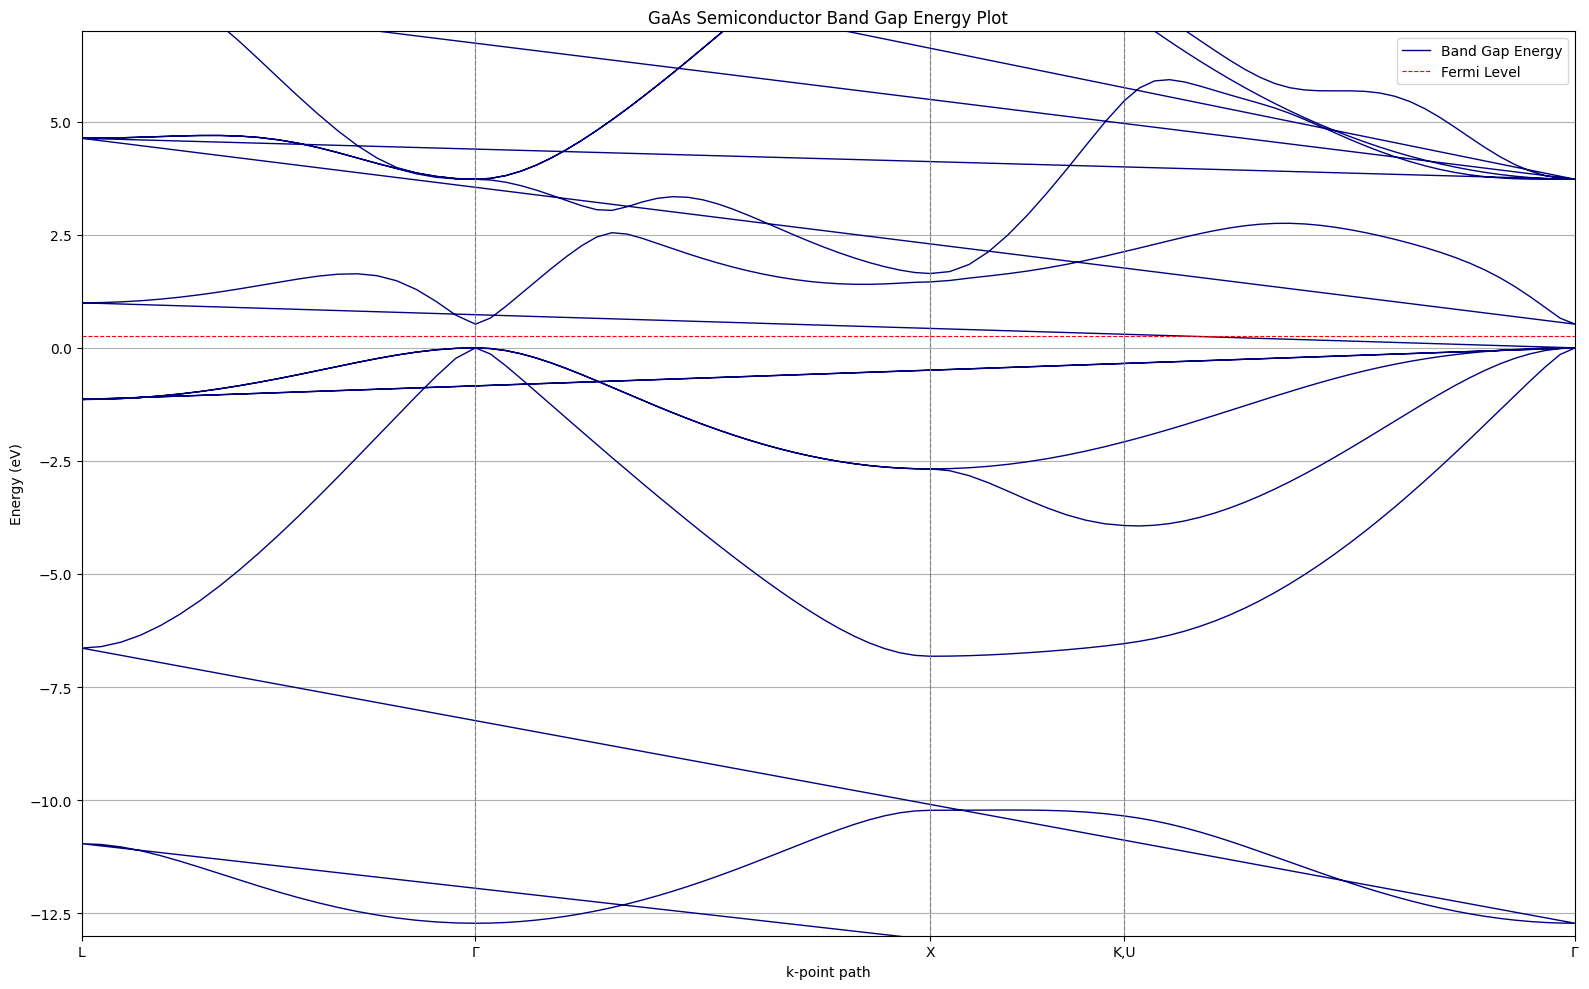

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Load Data from the File
data = np.loadtxt("Band/GaAs.band.gnu")

# Extract Energy and the 
k = data[:, 0]
E = data[:, 1]

# Define the Fermi Energy Shift
ef = 6.7106

# Define Graph Limits
xmax = 3.2844
ymin = -13
ymax = 7

# Define the 
x1 = 0.8660
x2 = 1.8660
x3 = 2.2932
xs = [x1, x2, x3]

# Plot the graph
plt.figure(figsize=(16, 10))
plt.plot(k, E - ef, linewidth=1, color='navy', label="Band Gap Energy")

# Plot the Variable Lines
for xline in xs:
    plt.axvline(x=xline, color='gray', linestyle='--', linewidth=0.8)

# Add X Ticks
plt.xticks(
    [0, x1, x2, x3, xmax],
    ["L", r"$\Gamma$", "X", "K,U", r"$\Gamma$"]
)

# Plot a Red Line for the Fermi Energy
plt.axhline(y=fermiEnergy, color='red', linestyle='--', linewidth=0.8, label="Fermi Level")

plt.ylabel("Energy (eV)")
plt.xlabel("k-point path")
plt.title("GaAs Semiconductor Band Gap Energy Plot")

plt.ylim(ymin, ymax)
plt.xlim(0, xmax)

plt.tight_layout()
plt.grid()
plt.legend()

plt.savefig("GaAs_band.png", dpi=300)
plt.show()

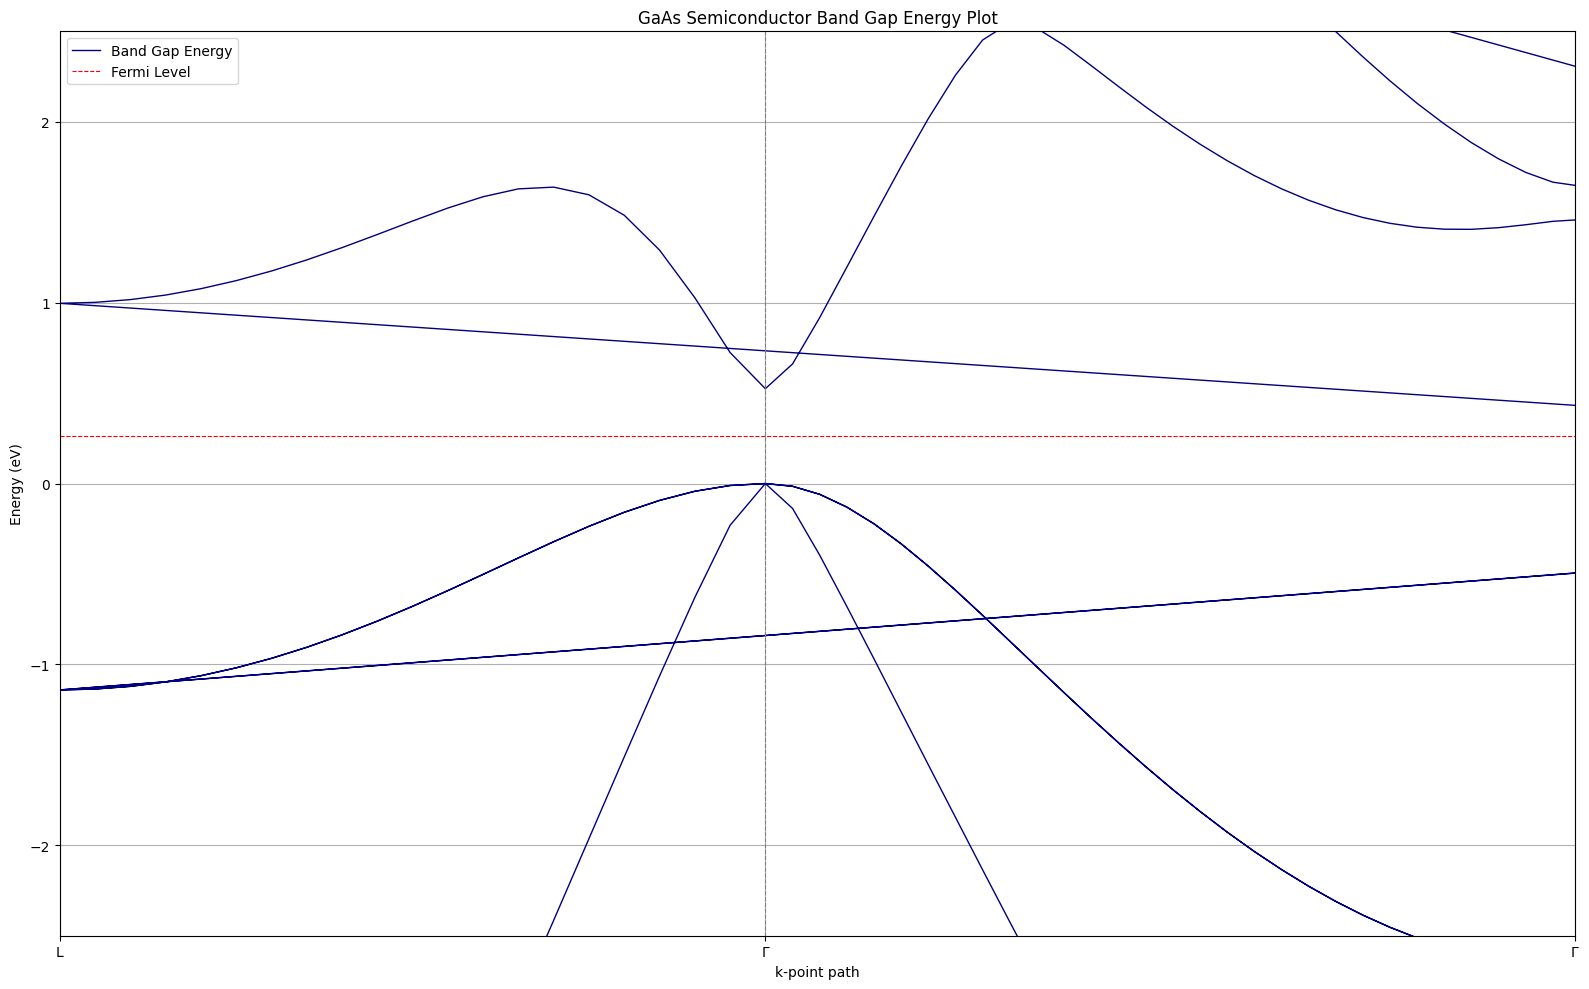

In [16]:
# Closer View at the Band Gap
import numpy as np
import matplotlib.pyplot as plt

# Load Data from the File
data = np.loadtxt("Band/GaAs.band.gnu")

# Extract Energy and the 
k = data[:, 0]
E = data[:, 1]

# Define the Fermi Energy Shift
ef = 6.7106

# Define Graph Limits
xmax = 1.86 #3.2844
ymin = -2.5
ymax = 2.5

# Define the 
x1 = 0.8660
x2 = 1.8660
x3 = 2.2932
xs = [x1, x2, x3]

# Plot the graph
plt.figure(figsize=(16, 10))
plt.plot(k, E - ef, linewidth=1, color='navy', label="Band Gap Energy")

# Plot the Variable Lines
for xline in xs:
    plt.axvline(x=xline, color='gray', linestyle='--', linewidth=0.8)

# Add X Ticks
plt.xticks(
    [0, x1, x2, x3, xmax],
    ["L", r"$\Gamma$", "X", "K,U", r"$\Gamma$"]
)

# Plot a Red Line for the Fermi Energy
plt.axhline(y=fermiEnergy, color='red', linestyle='--', linewidth=0.8, label="Fermi Level")

plt.ylabel("Energy (eV)")
plt.xlabel("k-point path")
plt.title("GaAs Semiconductor Band Gap Energy Plot")

plt.ylim(ymin, ymax)
plt.xlim(0, xmax)

plt.tight_layout()
plt.grid()
plt.legend()

plt.savefig("GaAs_band.png", dpi=300)
plt.show()


# 7. Assignment Questions
Answer the following in a short report :

1. What Is the fermi energy?
2. Why is the SCF calculation performed on a coarse k-point grid, while the NSCF calculation uses a dense path?
3. Is GaAs a direct or indirect semiconductor based on your calculation?
4. How did you decide on the number of bands?

## Answers
-------
### 1. What is the Fermi Energy
-------







# 8. Deliverables
Upload the following:

Your band structure plot (PNG )
Short Answer to the questions